# **Utilization of Node Embeddings in Predicting Employee Attrition (Or another strange title which i have no idea)**

**NOTE**: You can copy or edit this notebook. You can propose an update, point out the weak parts of the notebook or more. All are appreciated. Everyting that I wrote in this notebook came from the free sources on the internet so this is another free source you can learn from. 

**Why does this notebook even exist** :)

I was reading the networkx(you know the python library) docs to get an idea of how to analyze a graph network containing employee information of a company, then I ran across the node2vec(you also know this, don't you) library. Long story short, I wanted to write a notebook that demonstrates the use of node embeddings which will be used (or should i say 'utilized') on the HR data I was working.

# **Summary**

**First**, there will be a brief introduction about the methods of transforming the data to a numeric form.

**Second**, we will be seeing a networkx graph built on the IBM HR dataset,

**Third**, we will be fitting a node embedding model on the graph we just created,

**Fourth**, we will use the embeddings from the third step in predicting the attrition (I will not build fully optimized models since that is not the main point of this notebook. Also I have no intention of doing it. sad!)

**Conclusion**, I will summarize what has just happened in this notebook.


Let's get started.

# **First Part - Introduction (as i said, it will be brief, no irony)**

In order for most machine learning models to work, the information in the dataset needs to be represented numerically. After the dataset is represented numerically only then it can be fed into the models.My goal is to use a different transformation method called node embedding for evaluating the feature vectors. We will transform the categorical features in the dataset with the help of node2vec algorithm fitted on a graph network, instead of transforming the dataset using onehot, label or ordinal encoders.

We will explore the use of node vectors for predicting the employee attrition. This is an experimental work and it is intented to provide an alternative way of representing the data numerically and it needs further tuning. After getting the node vectors we can utilize them in any machine learning model and process as we wish.

In [1]:
# Required for node embeddings
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5978 sha256=edbc9229f8cf4a7bed2dfdf9227e37bda038e954b06b0b64ac81998108816044
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [2]:
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

import gensim
import networkx as nx
from node2vec import Node2Vec

from pandas_profiling import ProfileReport

attrition_data = '../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df_attrition = pd.read_csv(attrition_data)
df_attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


# **Second Part - Building the Networkx Graph on HR dataset**

(If you haven't heard the terms nodes, edges, graphs before, the internet will help you the most.)

First we will observe the profiling report from pandas_profiling. What it does is that it profiles the data(clearly explained, you can google it by the way if you don't believe me). This report includes visualizations for the distribution of data for each column as well as statistical measures. For example correlation is just one of them.

I took the notes of those columns which were highly correlated, also the columns that had mostly constant or null values. You could also run the profiler to get the report which was commented out.

Based on the above, I selected 6 columns, 5 as the features and 1 as the target, to build the graph. (Possible improvement point. feature selection can be done instead of blindly dropping the columns.)

There is a graph builder class that has two methods, namely, build_graph and draw_graph. Build_graph takes the dataframe in addition to node and edge lists. It creates an instance of networkx graph which can be visualized for later use. Draw graph displays a matplotlib figure containing the graph object created in the previous method. Nodes and edges can be configured in many ways. (Possible improvement point. Different node, edge combinations can be tried.)

There are two different graph objects. One is for visualization of the graph with a small number of data, and one is for the node embedding model to be fitted on.


In [3]:
# %%time
# profile = ProfileReport(df_attrition, title='Attirition profiling')
# profile.to_widgets()
# alternative way of displaying the report
# profile.to_notebook_iframe()

In [4]:
target_column = 'Attrition'
selected_columns = ['EmployeeNumber', 'BusinessTravel', 'Gender', 'JobRole', \
                    'MaritalStatus', 'OverTime', 'Attrition']

df_attrition = df_attrition.loc[:, selected_columns]
df_attrition

,EmployeeNumber,BusinessTravel,Gender,JobRole,MaritalStatus,OverTime,Attrition
0,1,Travel_Rarely,Female,Sales Executive,Single,Yes,Yes
1,2,Travel_Frequently,Male,Research Scientist,Married,No,No
2,4,Travel_Rarely,Male,Laboratory Technician,Single,Yes,Yes
3,5,Travel_Frequently,Female,Research Scientist,Married,Yes,No
4,7,Travel_Rarely,Male,Laboratory Technician,Married,No,No
...,...,...,...,...,...,...,...
1465,2061,Travel_Frequently,Male,Laboratory Technician,Married,No,No
1466,2062,Travel_Rarely,Male,Healthcare Representative,Married,No,No
1467,2064,Travel_Rarely,Male,Manufacturing Director,Married,Yes,No
1468,2065,Travel_Frequently,Male,Sales Executive,Married,No,No


In [5]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "EmployeeNumber":
                self.graph.nodes[node]["attributes"] = dataframe.loc[dataframe["EmployeeNumber"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "black"))
            return colors

        f = plt.figure(figsize = (20,12), facecolor="darkgray")
        ax = f.add_subplot()

        if not node:    
            plt.title(self.title)
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        nx.draw_networkx(graph, node_size = 800, node_color = colors, with_labels = True)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='employee no', markerfacecolor = node_colors['EmployeeNumber'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='travel', markerfacecolor = node_colors['BusinessTravel'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='gender', markerfacecolor = node_colors['Gender'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='job role', markerfacecolor = node_colors['JobRole'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='marital status', markerfacecolor = node_colors['MaritalStatus'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='overtime', markerfacecolor = node_colors['OverTime'], markersize=15),

        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

In [6]:
nodes = selected_columns[:-1] # Do not select Attrition as a feature node
edges = [("EmployeeNumber","BusinessTravel"),
         ("EmployeeNumber","Gender"),
         ("EmployeeNumber","JobRole"),
         ("EmployeeNumber","MaritalStatus"),
         ("EmployeeNumber","OverTime")]

node_colors = { # freestyle, update any color.
    "EmployeeNumber": "dodgerblue", 
    "BusinessTravel":"lightgreen", 
    "Gender":"tan", 
    "JobRole":"salmon",
    "MaritalStatus":"darkcyan",
    "OverTime":"lightblue"
}

FINISHED in 0.011 seconds.
Name: Employe Attrition graph with only 5 samples of data
Type: Graph
Number of nodes: 17
Number of edges: 30
Average degree:   3.5294


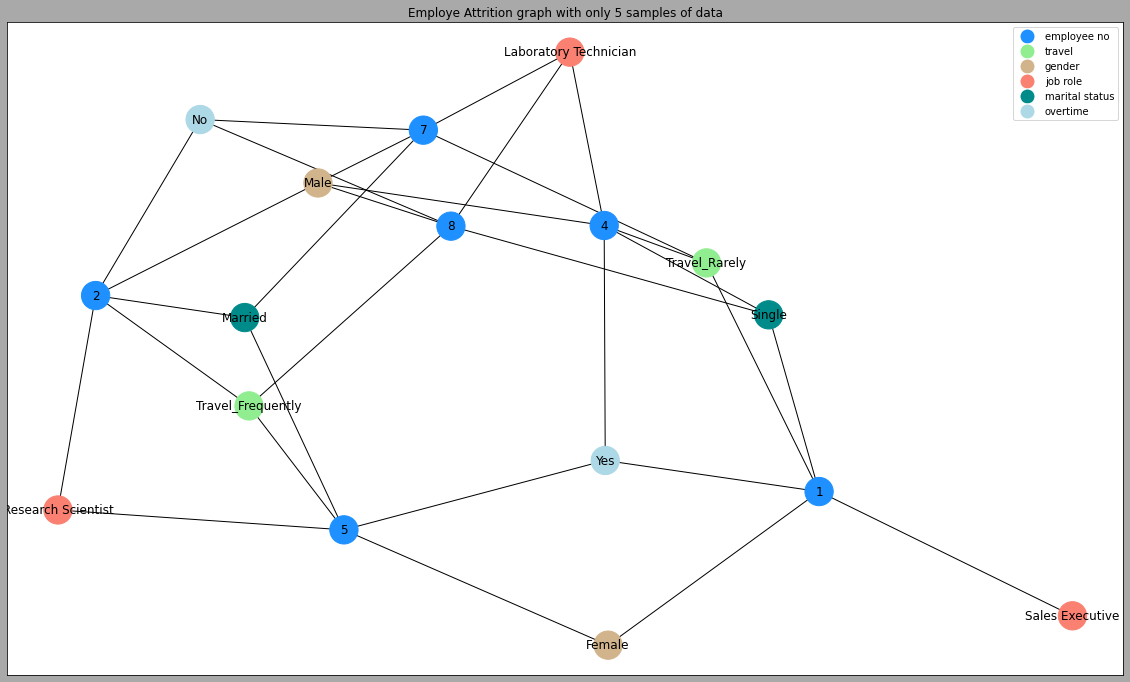

In [7]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:5, selected_columns[:-1]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Employe Attrition graph with only 5 samples of data'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph


When we look at the graph info below, we can see that there are 1489 nodes, 7350 edges. An every node has approximately 10 neighbors on average. Node number is different than the row number in the data since we are counting each unique value in all the feature columns, not just employee's but their attributes as well. We are drawing edges only between the employee and their attributes.


In [8]:
graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:-1]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Employe Attrition Graph'
)

FINISHED in 1.384 seconds.
Name: Employe Attrition Graph
Type: Graph
Number of nodes: 1489
Number of edges: 7350
Average degree:   9.8724


# **Third Part - Node Embeddings**

I will give a brief(again no irony) information on the node2vec algorithm then move onto fitting the embedding model.

**CAUTION**: If you are not really into definitions/theory behind the model and/or want to see only the implementation, skip this section right away.

(Pisst! are you still here, yes you, then let's move on)

For each node in the graph network, vector embeddings were obtained by using the complete graph. Starting from each node in the graph, algorithm moves over one of the adjacent edges to walk towards to a node based on a precomputed probability distribution. The number of steps that needs to be taken is a hyper parameter. After this process is repeated in a predefined number of times, a list of Random Walks is obtained for each node as below. These lists are fed into the word representation model along with the size of the embedding vectors. Finally, the vectors in the Embeddings list are obtained by giving this random walks' list into the Word2Vec model from gensim. 

Random Walks = {   

"Node1": [ ["Node1", "Node4", "Node55", . . .],   

        ["Node1", "Node33", "Node77"], ...],  

"Node2": [ [“Node2”, “Node17”, “Node88”, . . .],   

         [“Node2”, “Node7”, “Node79”], ...], ...   

} 


Embeddings = {   

 "Node1": [0.121, -0.215, 1.564, ...],   

 "Node2": [0.151, 0.251, -0.516, ...],   

 ...   

}   


The two parameters that are effective in probability calculations required before Random Walks are p and q. The type of graph (Directed/Undirected) determines which parameter will be used.  

P: The parameter that controls the probability of immediate return to the node walked over in the last step. 


Q: On directed graph networks, where the edges allow moving either inward or outward, q is the parameter that determines which type of edge has the higher probability to be selected.

(This is my definition of brief. I am assuming you did not close the notebook so far. maybe you will soon.)


In [9]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12

class VectorizerConfig:
    dimensions = 64
    walk_length = 30
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 4

class NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = Node2Vec(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> gensim.models.Word2Vec:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.model = self.vectorizer.fit(**params)
        
        return self.model

    def save_model(self, model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = VectorizerConfig.dimensions
        w = VectorizerConfig.walk_length
        n = VectorizerConfig.num_walks

        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}.pkl"
        # Save only the embeddings in a txt file.
        self.model.wv.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        self.model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")

    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> gensim.models.Word2Vec:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model


In [10]:
import multiprocessing

embedder = NodeEmbedding()

In [11]:
embedder.generate_random_walks(
    graph,
    dimensions = VectorizerConfig.dimensions,
    walk_length = VectorizerConfig.walk_length,
    num_walks = VectorizerConfig.num_walks,
    workers = multiprocessing.cpu_count()
)

Computing transition probabilities:   0%|          | 0/1489 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 13/13 [01:48<00:00,  8.34s/it]

In [12]:
%%time
model = embedder.fit(
    window = VectorizerConfig.window,
    min_count = VectorizerConfig.min_count,
    batch_words = VectorizerConfig.batch_words
)

CPU times: user 2min 16s, sys: 26.1 s, total: 2min 42s
Wall time: 1min 44s


In [13]:
embedder.save_model(model, save_to = EMBEDDINGS_DIR, prefix = "attrition")

Model and embeddings saved to: /kaggle/working/embeddings/attrition_model_64_30_50.pkl


In [14]:
model2 = embedder.load_model("attrition_model_64_30_50.pkl", load_from = EMBEDDINGS_DIR)

Loaded Model:  attrition_model_64_30_50.pkl


In [15]:
with open(EMBEDDINGS_DIR / 'attrition_embeddings_64_30_50.txt', 'r') as embeddings_file:
    embeddings = embeddings_file.readlines()

Embeddings were written to a txt file with the format:

[

node_count vector_dimension,

first_node_name value1_1 value1_2 ... value1_64

second_node_name value2_1 value2_2 ... value2_64

...

]

So the first element in the list is just information about the content hence not required. Also, we will only be taking the vectors of employee's not the vectors for their attributes.
    

In [16]:
embeddings[:3]

['1489 64\n',
 'No 0.12890157 0.02013395 0.24558993 -0.08271182 0.17435177 0.04770488 0.25083846 -0.024477156 0.13035327 0.05347328 0.114962675 0.012300068 -0.06749841 0.07574861 -0.10533206 -0.08722117 -0.03478902 0.0078043845 0.0041021593 0.103056975 0.3535569 0.114113845 0.175186 -0.098535284 -0.026019085 0.34062424 0.0023480426 0.19878797 -0.017179897 -0.119641535 0.013128106 -0.040090468 0.083980024 -0.3233608 0.024256242 0.18101308 -0.18171757 0.067335285 0.016174514 -0.07539347 -0.054705933 0.25571007 -0.011450646 -0.2747531 0.15653197 0.026137216 -0.18424922 -0.21029568 -0.06900918 0.020644624 -0.18597409 -0.00406084 0.12633276 0.1347335 0.3635615 -0.08382976 -0.024869485 -0.19835337 -0.032561973 -0.13368921 -0.06192756 0.22975823 0.040973153 -0.15114745\n',
 'Travel_Rarely -0.07389817 0.2294334 0.08523163 0.10201571 -0.015322167 -0.0750977 0.0029217028 0.24103361 -0.05968351 -0.009978623 0.28990743 0.2570256 0.037125066 -0.00010641756 0.07672262 -0.037678685 -0.018652432 0.343

In [17]:
# This function is requred since embeddings are out of order with the target. They were not matched correctly.
def align_features_and_target(df: pd.DataFrame, embeddings_file: str = None):
    vectors = []
    with Path(EMBEDDINGS_DIR / embeddings_file).open(mode="r") as file:
        results = file.readlines()
        for person in df["EmployeeNumber"].values:
            for line in results[1:]:
                if line.split()[0] == str(person):
                    vectors.append(line.split()[1:])
    
    return np.array(vectors).astype(np.float64)

In [18]:
%%time
embeddings_filename = "attrition_embeddings_64_30_50.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)

CPU times: user 12.1 s, sys: 524 ms, total: 12.6 s
Wall time: 12.6 s


In [19]:
feature_vectors.shape

(1470, 64)

In [20]:
node_targets = np.array(list(map(lambda label: 1 if label == "Yes" else 0, df_attrition["Attrition"])))
# node_targets = df_attrition_encoded['Attrition'].values
node_targets.shape


(1470,)

# **Fourth Part - Training the Models on Node Vectors**

We will first split the vectors into train and test sets. We will try 4 different classifier model from scikit-learn on the train sets then evaluate on the test sets. (Possible improvement point. Oversampling can be tried since the data is unbalanced.)

In [21]:
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(f'Original target value counts: {Counter(node_targets)}')
print(f'Train vectors shape: ', feature_vectors.shape)

x_train, x_test, y_train, y_test = train_test_split(
    feature_vectors, 
    node_targets, 
    test_size = 0.25,
    random_state = 12, 
    stratify = node_targets
)

classifiers = {
        'LogisticReg': LogisticRegression(), 
        'SVC': SVC(), 
        'GBC': GradientBoostingClassifier(),
        'kNN': KNeighborsClassifier()
}

scores = dict()
for name, classifier in classifiers.items():
        print(f'\n<------------- MODEL: {name} ----------->')
        classifier.fit(x_train, y_train)
        print(classification_report(y_test, classifier.predict(x_test), zero_division = 0))
        print(f'<------------- END ----------->\n')


Original target value counts: Counter({0: 1233, 1: 237})
Train vectors shape:  (1470, 64)

<------------- MODEL: LogisticReg ----------->
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       309
           1       0.48      0.19      0.27        59

    accuracy                           0.84       368
   macro avg       0.67      0.57      0.59       368
weighted avg       0.80      0.84      0.81       368

<------------- END ----------->


<------------- MODEL: SVC ----------->
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       309
           1       0.67      0.07      0.12        59

    accuracy                           0.85       368
   macro avg       0.76      0.53      0.52       368
weighted avg       0.82      0.85      0.79       368

<------------- END ----------->


<------------- MODEL: GBC ----------->
              precision    recall  f1-score   support

       

# **Conclusion**

(You still reading? huh!)

From the classification report, we can say that model performs poorly on the positive class but the overall results are not that horrible i could say. And as I mentioned in the summary, main point was to showcase the use of node embeddings. We saw how to create a graph with networkx configure it for visualization purposes. Then, we fed this graph into the node2vec model and get back a vector for every node in the graph. Even though we used those vectors in classification, we could use them in any other machine learning task such as regression, clustering etc. So, We saw that we could also use node embeddings in place of the onehot vectors or we could make a pipeline that uses these two methods together for further work.

These were all I wanted to say. If you have any questions feel free to ask.

### **Thanks for reading**
